In [1]:
# --- Preprocessing Cell ---

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTENC
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('../dataset.csv')

# Display initial information
print("Initial Data Shape:", data.shape)
print("Initial Data Columns:", data.columns.tolist())

# Drop unnecessary columns except 'patient_id' and 'hospital_death'
cols_to_drop = ['encounter_id', 'hospital_id', 'icu_id', 'Unnamed: 83', 'gcs_unable_apache']
data.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Replace "Undefined diagnoses" with "Undefined Diagnoses" in 'apache_2_bodysystem'
data['apache_2_bodysystem'] = data['apache_2_bodysystem'].replace('Undefined diagnoses', 'Undefined Diagnoses')

# Save Apache probabilities alongside 'patient_id' for later benchmarking
apache_probs_clean = data[['patient_id', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']].copy()

# Drop Apache probabilities from the main dataset
data.drop(columns=['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'], inplace=True, errors='ignore')

# Display data after initial cleaning
print("\nData after dropping unnecessary columns and saving Apache probabilities:")
print(data.head())

# Handle missing values
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("\nMissing Values in Each Column:")
print(missing_values)

# Drop rows with missing values
data.dropna(inplace=True)
print(f"\nData shape after dropping missing values: {data.shape}")

# Handle comorbidity variables
comorbidity_vars = [
    'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
    'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis'
]

# Ensure comorbidity variables are integers
data[comorbidity_vars] = data[comorbidity_vars].astype(int)

# Compute comorbidity count
data['comorbidity_count'] = data[comorbidity_vars].sum(axis=1)

# Handle GCS (Glasgow Coma Scale) variables
gcs_vars = ['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache']

# Convert GCS variables to numeric if not already
data[gcs_vars] = data[gcs_vars].apply(pd.to_numeric, errors='coerce')

# Compute GCS total
data['gcs_total'] = data[gcs_vars].sum(axis=1)

# Re-express categorical variables by combining certain categories

# Ethnicity: Combine 'Asian', 'Native American', 'Other/Unknown' into 'Other'
ethnicities_to_combine = ['Asian', 'Native American', 'Other/Unknown']
data['ethnicity'] = data['ethnicity'].apply(
    lambda x: x if x not in ethnicities_to_combine else 'Other'
)

# ICU Admit Source: Combine 'Other ICU' into 'Other'
icu_admit_sources_to_combine = ['Other ICU']
data['icu_admit_source'] = data['icu_admit_source'].apply(
    lambda x: x if x not in icu_admit_sources_to_combine else 'Other'
)

# ICU Type: Combine 'SICU', 'CTICU', 'CSICU' into 'Other'
icu_types_to_combine = ['SICU', 'CTICU', 'CSICU']
data['icu_type'] = data['icu_type'].apply(
    lambda x: x if x not in icu_types_to_combine else 'Other'
)

# APACHE 3J Bodysystem: Combine specific categories into 'Other'
apache_3j_bodysystem_to_combine = [
    'Gynecological',
    'Musculoskeletal/Skin',
    'Hematological',
    'Genitourinary',
    'Trauma',
    'Metabolic'
]
data['apache_3j_bodysystem'] = data['apache_3j_bodysystem'].apply(
    lambda x: x if x not in apache_3j_bodysystem_to_combine else 'Other'
)

# Drop individual comorbidity and GCS columns since we have the totals
data.drop(columns=comorbidity_vars + gcs_vars, inplace=True)

# Display data after feature engineering
print("\nData after Feature Engineering:")
print(data.head())

# Define categorical features based on understanding of data
categorical_features = [
    'ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type',
    'icu_type', 'apache_2_bodysystem', 'apache_3j_bodysystem'
]

# Identify numerical columns (excluding the target variable)
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
if 'hospital_death' in numerical_features:
    numerical_features.remove('hospital_death')

# Differentiate between binary and continuous numerical features
binary_columns = [col for col in categorical_features if data[col].nunique() == 2]
continuous_numerical_features = [col for col in numerical_features if col not in binary_columns]

# Print feature lists
print("\nContinuous Numerical Features:")
print(continuous_numerical_features)

print("\nCategorical Features:")
print(categorical_features)

print("\nBinary Categorical Features:")
print(binary_columns)

# Summary statistics for continuous numerical features
if continuous_numerical_features:
    print("\nSummary Statistics of Continuous Numerical Features:")
    print(data[continuous_numerical_features].describe())
else:
    print("\nNo Continuous Numerical Features to display.")

# Label Encode Categorical Features
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Save the encoder for future use

# Verify that all categorical features have been encoded
print("\nData Types After Label Encoding:")
print(data.dtypes)

# Scale Numerical Features with StandardScaler
scaler = StandardScaler()
features_to_scale = [col for col in numerical_features if col != 'hospital_death']
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

print("\nNumerical Features After Scaling:")
print(data[features_to_scale].head())

# Save the scaler for future use
joblib.dump(scaler, 'standard_scaler.joblib')
print("Scaler has been saved as 'standard_scaler.joblib'.")

# Define the target variable
target_column = 'hospital_death'

# Verify 'hospital_death' unique values
print("\nUnique values in 'hospital_death':")
print(data[target_column].unique())

# Define Features (X) and Target (y)
# Exclude 'patient_id' and 'hospital_death' from features
X = data.drop(columns=[target_column, 'patient_id'])
y = data[target_column]

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split the data into training and testing sets (80% train, 20% test)
# Stratify based on the target variable to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")

print("\nTraining Target Distribution:")
print(y_train.value_counts(normalize=True))

print("\nTesting Target Distribution:")
print(y_test.value_counts(normalize=True))

# Handle Class Imbalance with SMOTENC
# Define categorical features indices for SMOTENC based on X_train columns
categorical_features_indices = [X_train.columns.get_loc(col) for col in categorical_features]

# Initialize SMOTENC
smote_nc = SMOTENC(categorical_features=categorical_features_indices, random_state=42)

# Apply SMOTENC to the training data
print("\nApplying SMOTENC to the training data to handle class imbalance...")
X_train_smote, y_train_smote = smote_nc.fit_resample(X_train, y_train)

print("After SMOTENC:")
print(pd.Series(y_train_smote).value_counts(normalize=True))

# Save the SMOTENC object for future use
joblib.dump(smote_nc, 'smotenc_resampler.joblib')
print("SMOTENC object has been saved as 'smotenc_resampler.joblib'.")


Initial Data Shape: (91713, 85)
Initial Data Columns: ['encounter_id', 'patient_id', 'hospital_id', 'age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'heart_rate_apache', 'intubated_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'ventilated_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_dias


Using device: cpu

--- Fold 1 ---
Fold 1 ROC AUC: 0.9696, PR AUC: 0.9701

--- Fold 2 ---
Fold 2 ROC AUC: 0.9689, PR AUC: 0.9693

--- Fold 3 ---
Fold 3 ROC AUC: 0.9697, PR AUC: 0.9696

--- Fold 4 ---
Fold 4 ROC AUC: 0.9667, PR AUC: 0.9665

--- Fold 5 ---
Fold 5 ROC AUC: 0.9658, PR AUC: 0.9663

Average ROC AUC across 5 folds: 0.9681
Average PR AUC across 5 folds: 0.9684

Aggregated Confusion Matrix:
[[40999  4394]
 [ 4153 41240]]


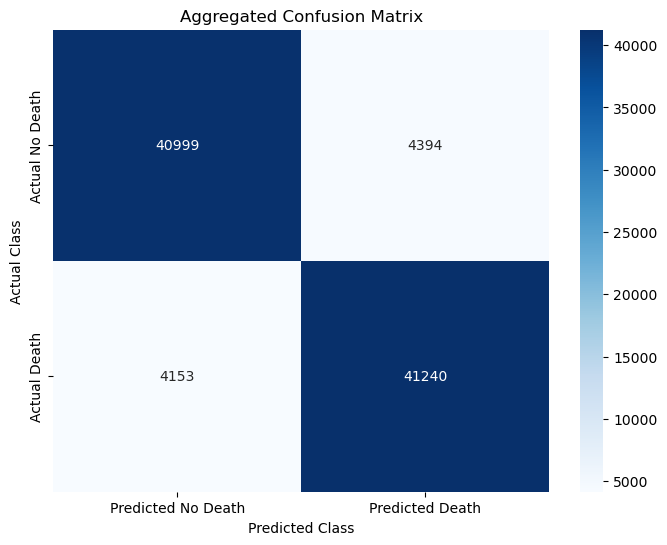


Overall Classification Report:
              precision    recall  f1-score   support

         0.0     0.9080    0.9032    0.9056     45393
         1.0     0.9037    0.9085    0.9061     45393

    accuracy                         0.9059     90786
   macro avg     0.9059    0.9059    0.9059     90786
weighted avg     0.9059    0.9059    0.9059     90786


Overall ROC AUC: 0.9680
Overall PR AUC: 0.9683

--- Training the Final MLP Model on the Entire Resampled Training Set ---

Epoch [1/50], Train Loss: 0.4406
Epoch [2/50], Train Loss: 0.3909
Epoch [3/50], Train Loss: 0.3708
Epoch [4/50], Train Loss: 0.3570
Epoch [5/50], Train Loss: 0.3464
Epoch [6/50], Train Loss: 0.3344
Epoch [7/50], Train Loss: 0.3257
Epoch [8/50], Train Loss: 0.3182
Epoch [9/50], Train Loss: 0.3120
Epoch [10/50], Train Loss: 0.3072
Epoch [11/50], Train Loss: 0.2999
Epoch [12/50], Train Loss: 0.2954
Epoch [13/50], Train Loss: 0.2939
Epoch [14/50], Train Loss: 0.2907
Epoch [15/50], Train Loss: 0.2876
Epoch [16/50], T

In [2]:
# --- Modeling Cell ---

# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    precision_recall_curve, average_precision_score
)
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Define the MLP Model in PyTorch
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, dropout_p=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, 1)
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x

# Define the Training Function with Early Stopping
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=50, patience=5, model_tag='model', verbose=True):
    best_loss = float('inf')
    trigger_times = 0
    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_train_loss = epoch_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        if val_loader is not None:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for X_val, y_val in val_loader:
                    X_val, y_val = X_val.to(device), y_val.to(device)
                    outputs = model(X_val)
                    loss = criterion(outputs, y_val)
                    val_loss += loss.item()
            avg_val_loss = val_loss / len(val_loader)
            history['val_loss'].append(avg_val_loss)

            if verbose:
                print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                trigger_times = 0
                torch.save(model.state_dict(), f'best_model_{model_tag}.pth')
            else:
                trigger_times += 1
                if verbose:
                    print(f"EarlyStopping counter: {trigger_times} out of {patience}")
                if trigger_times >= patience:
                    if verbose:
                        print("Early stopping triggered!")
                    break
        else:
            # No validation; just print training loss
            if verbose:
                print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")
    return model, history

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Initialize K-Fold Cross-Validation
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Load SMOTENC object
smote_nc = joblib.load('smotenc_resampler.joblib')

# Prepare SMOTENC-resampled data
X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

# Convert to numpy arrays
X_resampled = np.array(X_resampled)
y_resampled = np.array(y_resampled)

# Initialize lists to store metrics
fold_confusion_matrices = []
fold_classification_reports = []
fold_roc_auc_scores = []
fold_pr_auc_scores = []
all_y_true = []
all_y_pred_probs = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_resampled, y_resampled), 1):
    print(f"\n--- Fold {fold} ---")
    X_train_fold, X_val_fold = X_resampled[train_idx], X_resampled[val_idx]
    y_train_fold, y_val_fold = y_resampled[train_idx], y_resampled[val_idx]

    # Convert to PyTorch tensors
    X_train_fold_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
    y_train_fold_tensor = torch.tensor(y_train_fold, dtype=torch.float32).unsqueeze(1)
    X_val_fold_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
    
    if isinstance(y_val_fold, pd.Series):
        y_val_fold = y_val_fold.values
    y_val_fold_tensor = torch.tensor(y_val_fold, dtype=torch.float32).unsqueeze(1)

    # Create TensorDatasets and DataLoaders
    train_dataset_fold = TensorDataset(X_train_fold_tensor, y_train_fold_tensor)
    val_dataset_fold = TensorDataset(X_val_fold_tensor, y_val_fold_tensor)

    train_loader_fold = DataLoader(train_dataset_fold, batch_size=64, shuffle=True)
    val_loader_fold = DataLoader(val_dataset_fold, batch_size=64, shuffle=False)

    # Initialize a new model for each fold
    model_fold = MLP(input_dim=X_resampled.shape[1]).to(device)

    # Define loss function and optimizer
    criterion_fold = nn.BCELoss()
    optimizer_fold = optim.Adam(model_fold.parameters(), lr=0.001)

    # Train the model with reduced verbosity
    model_fold, history_fold = train_model(
        model=model_fold,
        criterion=criterion_fold,
        optimizer=optimizer_fold,
        train_loader=train_loader_fold,
        val_loader=val_loader_fold,
        device=device,
        num_epochs=50,
        patience=5,
        model_tag=f'MLP_Fold{fold}',
        verbose=False
    )

    # Evaluation
    model_fold.eval()
    y_pred_fold = []
    y_true_fold = []
    y_pred_probs_fold = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader_fold:
            X_batch = X_batch.to(device)
            outputs = model_fold(X_batch)
            y_pred_probs_fold.extend(outputs.cpu().numpy().flatten())
            y_true_fold.extend(y_batch.cpu().numpy().flatten())

    # Convert probabilities to binary predictions
    y_pred_binary_fold = [1 if prob >= 0.5 else 0 for prob in y_pred_probs_fold]

    # Confusion Matrix
    cm = confusion_matrix(y_true_fold, y_pred_binary_fold)
    fold_confusion_matrices.append(cm)

    # Classification Report
    report = classification_report(y_true_fold, y_pred_binary_fold, output_dict=True, zero_division=0)
    fold_classification_reports.append(report)

    # ROC AUC Score
    roc_auc = roc_auc_score(y_true_fold, y_pred_probs_fold)
    fold_roc_auc_scores.append(roc_auc)

    # PR AUC Score
    pr_auc = average_precision_score(y_true_fold, y_pred_probs_fold)
    fold_pr_auc_scores.append(pr_auc)

    # Append to all predictions
    all_y_true.extend(y_true_fold)
    all_y_pred_probs.extend(y_pred_probs_fold)

    print(f"Fold {fold} ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}")

# Calculate average ROC AUC and PR AUC
avg_roc_auc = np.mean(fold_roc_auc_scores)
avg_pr_auc = np.mean(fold_pr_auc_scores)
print(f"\nAverage ROC AUC across {k_folds} folds: {avg_roc_auc:.4f}")
print(f"Average PR AUC across {k_folds} folds: {avg_pr_auc:.4f}")

# Aggregate Confusion Matrices
aggregated_cm = np.sum(fold_confusion_matrices, axis=0)
print("\nAggregated Confusion Matrix:")
print(aggregated_cm)

# Plot Aggregated Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(aggregated_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No Death', 'Predicted Death'],
            yticklabels=['Actual No Death', 'Actual Death'])
plt.title('Aggregated Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Overall Classification Report
print("\nOverall Classification Report:")
print(classification_report(all_y_true, [1 if prob >=0.5 else 0 for prob in all_y_pred_probs], digits=4, zero_division=0))

# Calculate overall ROC AUC and PR AUC
overall_roc_auc = roc_auc_score(all_y_true, all_y_pred_probs)
overall_pr_auc = average_precision_score(all_y_true, all_y_pred_probs)
print(f"\nOverall ROC AUC: {overall_roc_auc:.4f}")
print(f"Overall PR AUC: {overall_pr_auc:.4f}")

# --- Final Model Training on the Entire Resampled Training Set ---

# Convert resampled training data to PyTorch tensors

if isinstance(X_train_smote, pd.DataFrame):
    X_train_smote_np = X_train_smote.values
else:
    X_train_smote_np = X_train_smote

X_train_smote_tensor = torch.tensor(X_train_smote_np, dtype=torch.float32)
y_train_smote_tensor = torch.tensor(y_train_smote, dtype=torch.float32).unsqueeze(1)

# Create TensorDataset and DataLoader
train_dataset_final = TensorDataset(X_train_smote_tensor, y_train_smote_tensor)
train_loader_final = DataLoader(train_dataset_final, batch_size=64, shuffle=True)


final_model = MLP(input_dim=X_train_smote.shape[1]).to(device)

# Define loss function and optimizer
criterion_final = nn.BCELoss()
optimizer_final = optim.Adam(final_model.parameters(), lr=0.001)


print("\n--- Training the Final MLP Model on the Entire Resampled Training Set ---\n")
final_model, history_final = train_model(
    model=final_model,
    criterion=criterion_final,
    optimizer=optimizer_final,
    train_loader=train_loader_final,
    val_loader=None,  # No validation during final training
    device=device,
    num_epochs=50,
    patience=5,
    model_tag='Final_Model',
    verbose=True
)

# Save the final model
torch.save(final_model.state_dict(), 'best_model_Final_Model.pth')
print("Final model trained and saved as 'best_model_Final_Model.pth'.")


Final model loaded and set to evaluation mode.

Predictions on the test set generated.
Model predictions saved to 'mlp_model_predictions.csv'.

Found 1032 NaN values in 'apache_4a_hospital_death_prob'. These rows will be dropped.

MLP Model Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91     10376
           1       0.30      0.62      0.40       983

    accuracy                           0.84     11359
   macro avg       0.63      0.74      0.65     11359
weighted avg       0.90      0.84      0.86     11359


Apache 4a Hospital Death Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     10376
           1       0.44      0.41      0.43       983

    accuracy                           0.90     11359
   macro avg       0.69      0.68      0.69     11359
weighted avg       0.90      0.90      0.90     11359


MLP Model Confusion Matrix:
[[89

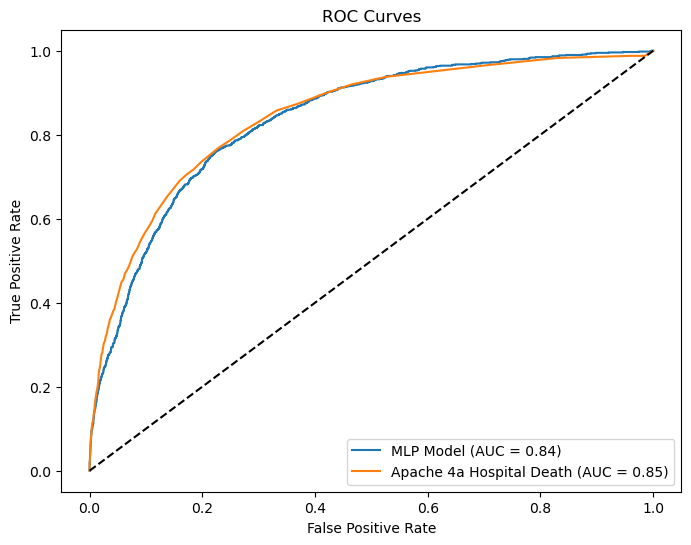

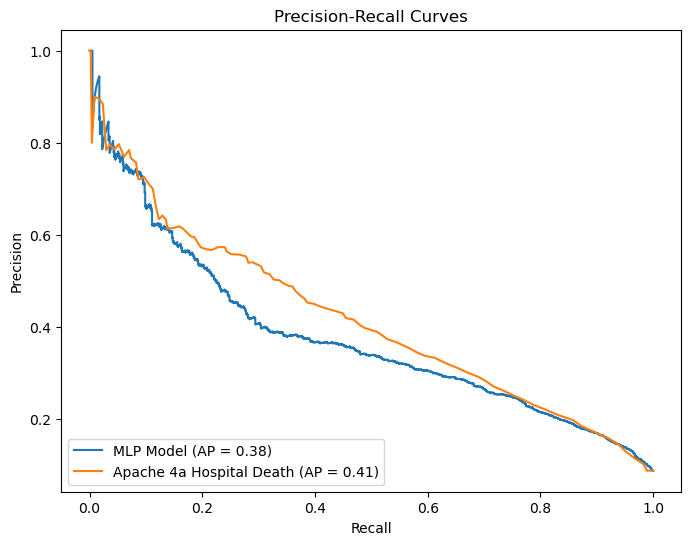

In [3]:
# --- Benchmarking Cell ---


import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Define the MLP Model in PyTorch (same architecture as before)
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, dropout_p=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, 1)
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x

# Initialize the model architecture
input_dim = X_train_smote.shape[1]
final_model = MLP(input_dim).to(device)

# Load the saved final model weights
final_model.load_state_dict(torch.load('best_model_Final_Model.pth'))
final_model.eval()
print("Final model loaded and set to evaluation mode.")

# Generate Predictions on the Test Set

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# Create a DataLoader for the test set
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Generate predicted probabilities
y_test_pred_probs = []
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch[0].to(device)
        outputs = final_model(X_batch)
        y_test_pred_probs.extend(outputs.cpu().numpy().flatten())

print("\nPredictions on the test set generated.")

# Align Predictions with `patient_id` and Save

# Retrieve 'patient_id' for the test set from 'apache_probs_clean' based on X_test indices
patient_id_test = apache_probs_clean.loc[X_test.index, 'patient_id'].values

# Create a DataFrame with 'patient_id' and predicted probabilities
model_predictions_df = pd.DataFrame({
    'patient_id': patient_id_test,
    'mlp_pred_prob': y_test_pred_probs
})

# Save model predictions to CSV for benchmarking
model_predictions_df.to_csv('mlp_model_predictions.csv', index=False)
print("Model predictions saved to 'mlp_model_predictions.csv'.")

# Benchmark Against Apache Scores

# Load Apache scores for the test set
apache_scores_test = apache_probs_clean.loc[X_test.index].copy()

# Create a DataFrame with 'patient_id' and 'y_true'
y_test_df = pd.DataFrame({
    'patient_id': patient_id_test,
    'y_true': y_test.values
})

# Merge model predictions with Apache scores and y_true on 'patient_id'
benchmarking_df = pd.merge(model_predictions_df, apache_scores_test, on='patient_id', how='inner')
benchmarking_df = pd.merge(benchmarking_df, y_test_df, on='patient_id', how='left')

# Check for NaN values in Apache scores
nan_apache = benchmarking_df['apache_4a_hospital_death_prob'].isnull().sum()
if nan_apache > 0:
    print(f"\nFound {nan_apache} NaN values in 'apache_4a_hospital_death_prob'. These rows will be dropped.")
    # Drop rows with NaN in 'apache_4a_hospital_death_prob'
    benchmarking_df = benchmarking_df.dropna(subset=['apache_4a_hospital_death_prob'])

# Now, y_true_benchmark corresponds to the remaining rows
y_true_benchmark = benchmarking_df['y_true'].values

# Define Predicted Labels from MLP Model and Apache using threshold 0.4
threshold = 0.4
y_pred_mlp_benchmark = (benchmarking_df['mlp_pred_prob'] >= threshold).astype(int)
y_pred_apache_hospital_benchmark = (benchmarking_df['apache_4a_hospital_death_prob'] >= threshold).astype(int)

# Classification Reports
print("\nMLP Model Classification Report:")
print(classification_report(y_true_benchmark, y_pred_mlp_benchmark, zero_division=0))

print("\nApache 4a Hospital Death Classification Report:")
print(classification_report(y_true_benchmark, y_pred_apache_hospital_benchmark, zero_division=0))

# Confusion Matrices
print("\nMLP Model Confusion Matrix:")
print(confusion_matrix(y_true_benchmark, y_pred_mlp_benchmark))

print("\nApache 4a Hospital Death Confusion Matrix:")
print(confusion_matrix(y_true_benchmark, y_pred_apache_hospital_benchmark))

# ROC AUC Scores
mlp_roc_auc_benchmark = roc_auc_score(y_true_benchmark, benchmarking_df['mlp_pred_prob'])
apache_roc_auc_benchmark = roc_auc_score(y_true_benchmark, benchmarking_df['apache_4a_hospital_death_prob'])

print(f"\nMLP Model ROC AUC Score: {mlp_roc_auc_benchmark:.4f}")
print(f"Apache 4a Hospital Death ROC AUC Score: {apache_roc_auc_benchmark:.4f}")

# Plot ROC Curves
fpr_mlp_benchmark, tpr_mlp_benchmark, _ = roc_curve(y_true_benchmark, benchmarking_df['mlp_pred_prob'])
fpr_apache_benchmark, tpr_apache_benchmark, _ = roc_curve(y_true_benchmark, benchmarking_df['apache_4a_hospital_death_prob'])

plt.figure(figsize=(8,6))
plt.plot(fpr_mlp_benchmark, tpr_mlp_benchmark, label=f'MLP Model (AUC = {mlp_roc_auc_benchmark:.2f})')
plt.plot(fpr_apache_benchmark, tpr_apache_benchmark, label=f'Apache 4a Hospital Death (AUC = {apache_roc_auc_benchmark:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curves
precision_mlp_benchmark, recall_mlp_benchmark, _ = precision_recall_curve(y_true_benchmark, benchmarking_df['mlp_pred_prob'])
precision_apache_benchmark, recall_apache_benchmark, _ = precision_recall_curve(y_true_benchmark, benchmarking_df['apache_4a_hospital_death_prob'])

ap_mlp_benchmark = average_precision_score(y_true_benchmark, benchmarking_df['mlp_pred_prob'])
ap_apache_benchmark = average_precision_score(y_true_benchmark, benchmarking_df['apache_4a_hospital_death_prob'])

plt.figure(figsize=(8,6))
plt.plot(recall_mlp_benchmark, precision_mlp_benchmark, label=f'MLP Model (AP = {ap_mlp_benchmark:.2f})')
plt.plot(recall_apache_benchmark, precision_apache_benchmark, label=f'Apache 4a Hospital Death (AP = {ap_apache_benchmark:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()
